In [48]:
import torch
import torchvision.transforms as transforms
import pandas as pd
import torch.nn as nn
import os
import warnings
import numpy as np
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, alexnet, densenet121, resnet34
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

warnings.filterwarnings('ignore')
DEVICE = 'cuda:0'

In [58]:
class MyDataset(Dataset):
    
    def __init__(self, base_dir, csv_data, mode='train', choose=None):
        self.base_dir = base_dir
        self.data = csv_data
        self.mode = mode
        self.over_sample = SMOTE(random_state=0)
        self.choose = choose

        if mode == 'train':
            self.transform = transforms.Compose([
                transforms.ToPILImage(), 
                transforms.ToTensor(),
                transforms.Normalize((0.59685254, 0.59685254, 0.59685254), (0.16043035, 0.16043035, 0.16043035))
            ])
        else:
        
            self.transform = transforms.Compose([
                transforms.ToPILImage(), 
                transforms.ToTensor(),
                transforms.Normalize((0.59685254, 0.59685254, 0.59685254), (0.16043035, 0.16043035, 0.16043035))
            ])
        self.__preprocess_data()
        
    
    def __preprocess_data(self):
        if self.choose is None:
            image_paths = [os.path.join(self.base_dir, path) for path in self.data[0]]
            labels = [int(prob * 3) for prob in self.data[2]]
        else:
            image_paths = [os.path.join(self.base_dir, path) for idx, path in enumerate(self.data[0]) if self.data[19].iloc[idx] == self.choose]
            labels = [int(prob * 3) for idx, prob in enumerate(self.data[2]) if self.data[19].iloc[idx] == self.choose]
        if self.mode == 'train':
            resample_indices, _ = self.over_sample.fit_resample(np.array(range(len(labels))).reshape(-1, 1), labels)
        else:
            resample_indices = np.array(range(len(labels))).reshape(-1, 1)
        self.data = [(image_paths[idx.item()], labels[idx.item()]) for idx in resample_indices]
        
    def load_image(self, image_path):
        image = np.array(Image.open(image_path).convert('RGB'))
        image = self.transform(image)
        return image
    
    def __getitem__(self, idx):
        image_path, multi_label = self.data[idx]
        image = self.load_image(image_path)
        return image, multi_label
    
    def __len__(self):
        return len(self.data)
        
        
        

In [39]:
class MyModel(nn.Module):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.backbone = alexnet(pretrained=False)
        self.backbone.fc = nn.Sequential(nn.Linear(512, 4), nn.Softmax(dim=-1))
    
    
    def forward(self, inputs):
        outputs = self.backbone(inputs)
        return outputs
        

In [40]:
from tqdm import tqdm

def train_loop(train_dataloader, model, loss_fn, optimizer, epoch_num):
    truth = []
    preds = []
    avg_loss = 0.0
    step_num = 0
    pbar = tqdm(train_dataloader, desc=f'Epoch {epoch_num}')
    for images, multi_labels in pbar:
        images = images.to(DEVICE)
        multi_labels = multi_labels.to(DEVICE)
        optimizer.zero_grad()
        multi_outputs = model(images)
        multi_preds = torch.argmax(multi_outputs, dim=-1)
        preds += multi_preds.reshape(-1).tolist()
        truth += multi_labels.reshape(-1).tolist()
        f1 = f1_score(truth, preds, average='macro')
        acc = accuracy_score(truth, preds)
        loss = loss_fn(multi_outputs, multi_labels)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        step_num += 1
        pbar.set_postfix(
        {'Train Loss': loss.item(),
         'Train Acc': acc,
         'Train F1': f1
        }
        )
    avg_loss /= step_num
    return avg_loss



def eval_loop(test_dataloader, model, loss_fn, epoch_num):
        with torch.no_grad():
            avg_loss = 0.0
            step_num = 0
            preds = []
            truth = []
            pbar = tqdm(test_dataloader, desc=f'Epoch {epoch_num}')
            for images, multi_labels in pbar:
                images = images.to(DEVICE)
                multi_labels = multi_labels.to(DEVICE)
                multi_outputs = model(images)
                multi_preds = torch.argmax(multi_outputs, dim=-1)
                preds += multi_preds.reshape(-1).tolist()
                truth += multi_labels.reshape(-1).tolist()
                f1 = f1_score(truth, preds, average='macro')
                acc = accuracy_score(truth, preds)
                loss = loss_fn(multi_outputs, multi_labels)
                avg_loss += loss.item()
                step_num += 1
                pbar.set_postfix(
                    {'Test Loss': loss.item(),
                     'Test Acc': acc,
                     'Test F1': f1
                    }
                    )
            avg_loss /= step_num
            return avg_loss


In [41]:
# train
label_path = '/kaggle/input/elpv-dataset-master/labels.csv'
image_dir = '/kaggle/input/elpv-dataset-master/images'

csv_data = pd.read_csv(label_path, sep=' ', header=None)
train_data, test_data = train_test_split(csv_data, test_size=0.25, random_state=0)
train_dataset = MyDataset(image_dir, train_data, 'train')
test_dataset = MyDataset(image_dir, test_data, 'test')
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

model = MyModel().to(DEVICE)

lr = 0.001
epochs = 60

multi_loss = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = 0.001) 


for epoch in range(epochs):
    train_loss = train_loop(train_dataloader, model, multi_loss, optimizer, epoch)
    test_loss = eval_loop(test_dataloader, model, multi_loss, epoch)
    print(f'Epoch {epoch} | Train loss {train_loss} | Test Loss {test_loss}')

Epoch 0: 100%|██████████| 6/6 [00:02<00:00,  2.01it/s, Test Loss=0.617, Test Acc=0.642, Test F1=0.333]


Epoch 0 | Train loss 2.8402054243617587 | Test Loss 0.9452676574389139


Epoch 1: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s, Test Loss=0.453, Test Acc=0.642, Test F1=0.334]


Epoch 1 | Train loss 1.0281258639362123 | Test Loss 0.8991345266501108


Epoch 2: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s, Test Loss=0.598, Test Acc=0.657, Test F1=0.341]


Epoch 2 | Train loss 1.008131581876013 | Test Loss 0.9116473396619161


Epoch 3: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s, Test Loss=0.326, Test Acc=0.665, Test F1=0.344]


Epoch 3 | Train loss 0.9773435178730223 | Test Loss 0.8615350524584452


Epoch 4: 100%|██████████| 6/6 [00:02<00:00,  2.03it/s, Test Loss=0.623, Test Acc=0.678, Test F1=0.354]


Epoch 4 | Train loss 0.999122702413135 | Test Loss 0.8915657699108124


Epoch 5: 100%|██████████| 6/6 [00:02<00:00,  2.09it/s, Test Loss=0.487, Test Acc=0.66, Test F1=0.333] 


Epoch 5 | Train loss 0.9831873741414812 | Test Loss 0.877931609749794


Epoch 6: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s, Test Loss=0.568, Test Acc=0.663, Test F1=0.347]


Epoch 6 | Train loss 0.9656296256515715 | Test Loss 0.8953408201535543


Epoch 7: 100%|██████████| 6/6 [00:03<00:00,  1.98it/s, Test Loss=0.731, Test Acc=0.666, Test F1=0.413]


Epoch 7 | Train loss 0.9715749323368073 | Test Loss 0.9487488071123759


Epoch 8: 100%|██████████| 6/6 [00:02<00:00,  2.03it/s, Test Loss=0.638, Test Acc=0.66, Test F1=0.344] 


Epoch 8 | Train loss 0.9628848085800806 | Test Loss 0.9048987329006195


Epoch 9: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s, Test Loss=0.569, Test Acc=0.678, Test F1=0.352]


Epoch 9 | Train loss 0.9373860441976123 | Test Loss 0.8453782399495443


Epoch 10: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s, Test Loss=0.574, Test Acc=0.662, Test F1=0.381]


Epoch 10 | Train loss 0.9265808910131454 | Test Loss 0.9173638125260671


Epoch 11: 100%|██████████| 6/6 [00:02<00:00,  2.05it/s, Test Loss=0.56, Test Acc=0.677, Test F1=0.386] 


Epoch 11 | Train loss 0.9345738308297263 | Test Loss 0.8542976876099905


Epoch 12: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s, Test Loss=0.516, Test Acc=0.686, Test F1=0.358]


Epoch 12 | Train loss 0.9261239220698675 | Test Loss 0.8266715010007223


Epoch 13: 100%|██████████| 6/6 [00:02<00:00,  2.15it/s, Test Loss=0.659, Test Acc=0.68, Test F1=0.42]  


Epoch 13 | Train loss 0.9178501930501726 | Test Loss 0.8796584606170654


Epoch 14: 100%|██████████| 6/6 [00:02<00:00,  2.01it/s, Test Loss=0.57, Test Acc=0.688, Test F1=0.365] 


Epoch 14 | Train loss 0.9035502026478449 | Test Loss 0.8494662046432495


Epoch 15: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s, Test Loss=0.562, Test Acc=0.675, Test F1=0.394]


Epoch 15 | Train loss 0.9162664496236377 | Test Loss 0.852785050868988


Epoch 16: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s, Test Loss=0.419, Test Acc=0.694, Test F1=0.404]


Epoch 16 | Train loss 0.9048174603117837 | Test Loss 0.8145445287227631


Epoch 17: 100%|██████████| 6/6 [00:03<00:00,  1.94it/s, Test Loss=0.414, Test Acc=0.692, Test F1=0.391]


Epoch 17 | Train loss 0.8939784202310774 | Test Loss 0.8051268955071768


Epoch 18: 100%|██████████| 6/6 [00:03<00:00,  1.91it/s, Test Loss=0.507, Test Acc=0.686, Test F1=0.443]


Epoch 18 | Train loss 0.8833471669091119 | Test Loss 0.8401955962181091


Epoch 19: 100%|██████████| 6/6 [00:02<00:00,  2.14it/s, Test Loss=0.484, Test Acc=0.681, Test F1=0.384]


Epoch 19 | Train loss 0.8763083434767194 | Test Loss 0.8225273489952087


Epoch 20: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s, Test Loss=0.464, Test Acc=0.706, Test F1=0.439]


Epoch 20 | Train loss 0.8661681628889508 | Test Loss 0.8035702407360077


Epoch 21: 100%|██████████| 6/6 [00:03<00:00,  1.99it/s, Test Loss=0.451, Test Acc=0.689, Test F1=0.413]


Epoch 21 | Train loss 0.858106361495124 | Test Loss 0.8190435270468394


Epoch 22: 100%|██████████| 6/6 [00:02<00:00,  2.03it/s, Test Loss=0.311, Test Acc=0.7, Test F1=0.382]  


Epoch 22 | Train loss 0.854009265700976 | Test Loss 0.8757657160361608


Epoch 23: 100%|██████████| 6/6 [00:03<00:00,  1.84it/s, Test Loss=0.364, Test Acc=0.706, Test F1=0.415]


Epoch 23 | Train loss 0.8401246749692493 | Test Loss 0.8040144344170889


Epoch 24: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s, Test Loss=0.458, Test Acc=0.678, Test F1=0.417]


Epoch 24 | Train loss 0.7961201303535037 | Test Loss 0.8825501600901285


Epoch 25: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s, Test Loss=0.447, Test Acc=0.678, Test F1=0.419]


Epoch 25 | Train loss 0.8035981688234541 | Test Loss 0.8372965604066849


Epoch 26: 100%|██████████| 6/6 [00:03<00:00,  2.00it/s, Test Loss=0.378, Test Acc=0.712, Test F1=0.444]


Epoch 26 | Train loss 0.7761526935630374 | Test Loss 0.7759162982304891


Epoch 27: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s, Test Loss=0.54, Test Acc=0.712, Test F1=0.468] 


Epoch 27 | Train loss 0.7797842737701204 | Test Loss 0.8182089229424795


Epoch 28: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s, Test Loss=0.491, Test Acc=0.683, Test F1=0.453]


Epoch 28 | Train loss 0.7136943224403594 | Test Loss 0.8312418709198633


Epoch 29: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s, Test Loss=0.202, Test Acc=0.713, Test F1=0.409]


Epoch 29 | Train loss 0.6831685619221793 | Test Loss 0.8013972515861193


Epoch 30: 100%|██████████| 6/6 [00:02<00:00,  2.01it/s, Test Loss=0.357, Test Acc=0.692, Test F1=0.471]


Epoch 30 | Train loss 0.6942066931062274 | Test Loss 0.8522353569666544


Epoch 31: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s, Test Loss=0.326, Test Acc=0.694, Test F1=0.428]


Epoch 31 | Train loss 0.6345120486285951 | Test Loss 0.8505866626898447


Epoch 32: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s, Test Loss=0.307, Test Acc=0.7, Test F1=0.448]  


Epoch 32 | Train loss 0.6343488958146837 | Test Loss 0.8941479325294495


Epoch 33: 100%|██████████| 6/6 [00:02<00:00,  2.14it/s, Test Loss=0.29, Test Acc=0.704, Test F1=0.41]  


Epoch 33 | Train loss 0.5928366763724221 | Test Loss 0.9425976673762003


Epoch 34: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s, Test Loss=0.396, Test Acc=0.709, Test F1=0.484]


Epoch 34 | Train loss 0.5761602761016952 | Test Loss 0.9944390753904978


Epoch 35: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s, Test Loss=0.341, Test Acc=0.706, Test F1=0.484]


Epoch 35 | Train loss 0.4979408085346222 | Test Loss 1.0321511775255203


Epoch 36: 100%|██████████| 6/6 [00:02<00:00,  2.10it/s, Test Loss=0.264, Test Acc=0.681, Test F1=0.471]


Epoch 36 | Train loss 0.5232789450221591 | Test Loss 0.8843141198158264


Epoch 37: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s, Test Loss=0.295, Test Acc=0.669, Test F1=0.455]


Epoch 37 | Train loss 0.44306637595097226 | Test Loss 0.9617158472537994


Epoch 38: 100%|██████████| 6/6 [00:02<00:00,  2.15it/s, Test Loss=0.355, Test Acc=0.672, Test F1=0.5]  


Epoch 38 | Train loss 0.4873609667023023 | Test Loss 0.9084237416585287


Epoch 39: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s, Test Loss=0.369, Test Acc=0.643, Test F1=0.471]


Epoch 39 | Train loss 0.39526758218804997 | Test Loss 1.0269685139258702


Epoch 40: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s, Test Loss=0.396, Test Acc=0.639, Test F1=0.492]


Epoch 40 | Train loss 0.4192039776179526 | Test Loss 1.003756269812584


Epoch 41: 100%|██████████| 6/6 [00:02<00:00,  2.06it/s, Test Loss=0.434, Test Acc=0.681, Test F1=0.501]


Epoch 41 | Train loss 0.3902232013642788 | Test Loss 1.1076072305440903


Epoch 42: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s, Test Loss=0.344, Test Acc=0.681, Test F1=0.485]


Epoch 42 | Train loss 0.3302578069269657 | Test Loss 1.154796635111173


Epoch 43: 100%|██████████| 6/6 [00:02<00:00,  2.09it/s, Test Loss=0.443, Test Acc=0.636, Test F1=0.457]


Epoch 43 | Train loss 0.3068401664495468 | Test Loss 1.199945017695427


Epoch 44: 100%|██████████| 6/6 [00:02<00:00,  2.16it/s, Test Loss=0.194, Test Acc=0.652, Test F1=0.48]


Epoch 44 | Train loss 0.28105462673637605 | Test Loss 1.165864735841751


Epoch 45: 100%|██████████| 6/6 [00:02<00:00,  2.05it/s, Test Loss=0.374, Test Acc=0.674, Test F1=0.506]


Epoch 45 | Train loss 0.26353367583619225 | Test Loss 1.2089808036883671


Epoch 46: 100%|██████████| 6/6 [00:02<00:00,  2.03it/s, Test Loss=0.272, Test Acc=0.683, Test F1=0.481]


Epoch 46 | Train loss 0.24540034102069008 | Test Loss 1.2211039115985234


Epoch 47: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s, Test Loss=0.128, Test Acc=0.694, Test F1=0.496]


Epoch 47 | Train loss 0.2686357945203781 | Test Loss 1.2717124844590824


Epoch 48: 100%|██████████| 6/6 [00:02<00:00,  2.03it/s, Test Loss=0.52, Test Acc=0.669, Test F1=0.482]


Epoch 48 | Train loss 0.2310850481606192 | Test Loss 1.1976598997910817


Epoch 49: 100%|██████████| 6/6 [00:02<00:00,  2.05it/s, Test Loss=0.35, Test Acc=0.665, Test F1=0.48] 


Epoch 49 | Train loss 0.22087830387883717 | Test Loss 1.3505705793698628


Epoch 50: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s, Test Loss=0.486, Test Acc=0.677, Test F1=0.508]


Epoch 50 | Train loss 0.2149979927473598 | Test Loss 1.304311196009318


Epoch 51: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s, Test Loss=0.444, Test Acc=0.681, Test F1=0.523]


Epoch 51 | Train loss 0.2022985073013438 | Test Loss 1.51837723950545


Epoch 52: 100%|██████████| 6/6 [00:02<00:00,  2.04it/s, Test Loss=0.363, Test Acc=0.655, Test F1=0.497]


Epoch 52 | Train loss 0.2106387292345365 | Test Loss 1.2286821951468785


Epoch 53: 100%|██████████| 6/6 [00:02<00:00,  2.09it/s, Test Loss=0.199, Test Acc=0.675, Test F1=0.47]


Epoch 53 | Train loss 0.18022560079892477 | Test Loss 1.5828230703870456


Epoch 54: 100%|██████████| 6/6 [00:02<00:00,  2.15it/s, Test Loss=0.351, Test Acc=0.674, Test F1=0.484]


Epoch 54 | Train loss 0.20721959550347593 | Test Loss 1.3231322069962819


Epoch 55: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s, Test Loss=0.331, Test Acc=0.688, Test F1=0.466]


Epoch 55 | Train loss 0.19328914334376654 | Test Loss 1.5200233707825344


Epoch 56: 100%|██████████| 6/6 [00:02<00:00,  2.16it/s, Test Loss=0.541, Test Acc=0.688, Test F1=0.475]


Epoch 56 | Train loss 0.1704852535492844 | Test Loss 1.521494338909785


Epoch 57: 100%|██████████| 6/6 [00:02<00:00,  2.10it/s, Test Loss=0.461, Test Acc=0.672, Test F1=0.439]


Epoch 57 | Train loss 0.1784342529459132 | Test Loss 1.5220807393391926


Epoch 58: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s, Test Loss=0.167, Test Acc=0.683, Test F1=0.512]


Epoch 58 | Train loss 0.17455665291183525 | Test Loss 1.473861816028754


Epoch 59: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s, Test Loss=0.552, Test Acc=0.678, Test F1=0.527]

Epoch 59 | Train loss 0.13235456662045586 | Test Loss 1.7305225829283397


Predicting: 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]

Poly:
Accurcay:  0.6859756097560976
F1 Score:  0.4923807836399989
Confusion Matrix: 
 [[302  23   7  43]
 [ 35  32   2   9]
 [ 16   7   2   2]
 [ 51   6   5 114]]


<Axes: >

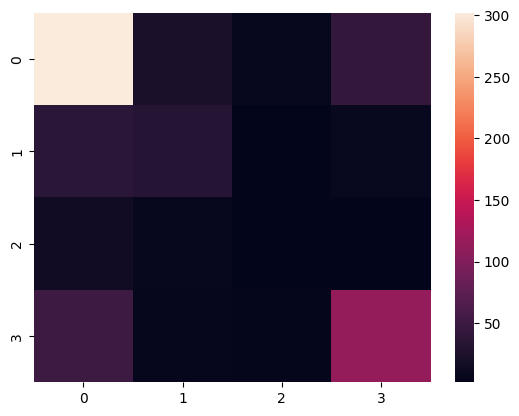

In [77]:
test_dataset = MyDataset(image_dir, test_data, 'test')
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

with torch.no_grad():
    preds = []
    truth = []
    pbar = tqdm(test_dataloader, desc=f'Predicting')
    for images, multi_labels in pbar:
        images = images.to(DEVICE)
        multi_labels = multi_labels.to(DEVICE)
        multi_outputs = model(images)
        multi_preds = torch.argmax(multi_outputs, dim=-1)
        preds += multi_preds.reshape(-1).tolist()
        truth += multi_labels.reshape(-1).tolist()
        
        
acc = accuracy_score(truth, preds)
f1 = f1_score(truth, preds, average='macro')
cm = confusion_matrix(truth, preds)

print('Poly:')
print('Accurcay: ', acc)
print('F1 Score: ', f1)
print('Confusion Matrix: \n', cm)
sns.heatmap(cm)

Predicting: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

Poly:
Accurcay:  0.7432432432432432
F1 Score:  0.3789586095153925
Confusion Matrix: 
 [[114   8   5  12]
 [  0   0   0   0]
 [  0   0   0   0]
 [ 26   2   4  51]]


<Axes: >

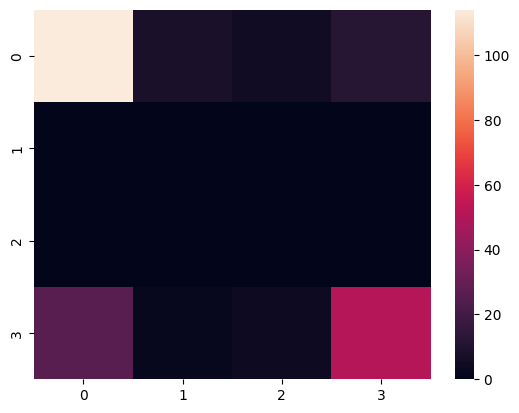

In [78]:
test_dataset = MyDataset(image_dir, test_data, 'test', 'mono')
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

with torch.no_grad():
    preds = []
    truth = []
    pbar = tqdm(test_dataloader, desc=f'Predicting')
    for images, multi_labels in pbar:
        images = images.to(DEVICE)
        multi_labels = multi_labels.to(DEVICE)
        multi_outputs = model(images)
        multi_preds = torch.argmax(multi_outputs, dim=-1)
        preds += multi_preds.reshape(-1).tolist()
        truth += multi_labels.reshape(-1).tolist()
        
        
acc = accuracy_score(truth, preds)
f1 = f1_score(truth, preds, average='macro')
cm = confusion_matrix(truth, preds)

print('Poly:')
print('Accurcay: ', acc)
print('F1 Score: ', f1)
print('Confusion Matrix: \n', cm)
sns.heatmap(cm)

Predicting: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

Poly:
Accurcay:  0.7386018237082067
F1 Score:  0.3590323201231243
Confusion Matrix: 
 [[187  13   1  35]
 [  0   0   0   0]
 [  0   0   0   0]
 [ 29   6   2  56]]


<Axes: >

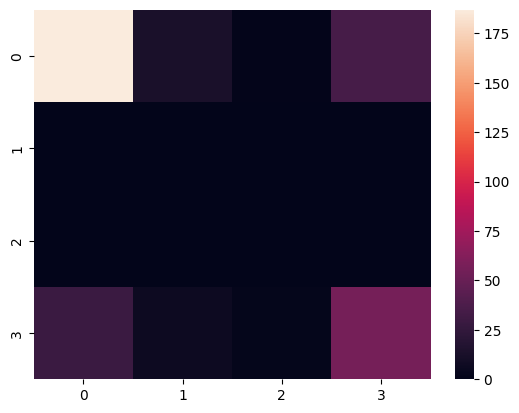

In [79]:
test_dataset = MyDataset(image_dir, test_data, 'test', 'poly')
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

with torch.no_grad():
    preds = []
    truth = []
    pbar = tqdm(test_dataloader, desc=f'Predicting')
    for images, multi_labels in pbar:
        images = images.to(DEVICE)
        multi_labels = multi_labels.to(DEVICE)
        multi_outputs = model(images)
        multi_preds = torch.argmax(multi_outputs, dim=-1)
        preds += multi_preds.reshape(-1).tolist()
        truth += multi_labels.reshape(-1).tolist()
        
        
acc = accuracy_score(truth, preds)
f1 = f1_score(truth, preds, average='macro')
cm = confusion_matrix(truth, preds)

print('Poly:')
print('Accurcay: ', acc)
print('F1 Score: ', f1)
print('Confusion Matrix: \n', cm)
sns.heatmap(cm)